## Importing Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_text as text
import numpy as np
import seaborn as sn

##### Creating environment to train the model

In [2]:
csv_file = "resources/model1.csv"
df_balanced = pd.read_csv(csv_file)
df_balanced.head()

,text,reaction,encoded_reaction
0,We were here yesterday for a bachelorette part...,satisfied considerable comment,0
1,"4-stars for food, 2-stars for service. I'm pr...",satisfied considerable comment,0
2,"The store itself is so iconic, don't let the t...",satisfied considerable comment,0
3,every single dessert looked so yummy and tempt...,satisfied considerable comment,0
4,"First time visit today, 12-27-21, when visitin...",satisfied considerable comment,0


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 783582087494142310
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2241331200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6931044360095677776
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
print(tf.test.is_built_with_cuda())

True


In [5]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['text'], df_balanced['encoded_reaction'], stratify=df_balanced['encoded_reaction'])
y_train.head(5)

180509    3
1427      0
155008    3
82361     2
51841     2
Name: encoded_reaction, dtype: int64

In [6]:
print(any(x is None or x.lower() == 'nan' for x in X_train))

False


In [7]:
print(y_train.dtype)

int64


In [8]:
print(y_train.shape)

(143538,)


## BERT encoding
##### We are using BERT to encode our text data into 784 dimensions

In [9]:
# Importing BERT
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [10]:
# BERT function
def embedding_generator(review):
    preprocessed_review = bert_preprocess(review)
    return bert_encoder(preprocessed_review)['pooled_output']

## Defining the models architecture
##### Layers used are as below
* Input Layer
* Lambda Layer
* Dropout Layer
* Dense Layer

In [11]:
# Constructing layers
# Input Layer
review_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input")
bert_out = embedding_generator(review_input)

# Modify the output layer to add epsilon to predicted probabilities
epsilon = 1e-7
layer = tf.keras.layers.Lambda(lambda x: x + epsilon, name='add_epsilon')(bert_out)

# Neural Network Layers
num_classes = 4
layer = tf.keras.layers.Dropout(0.1, name='dropout')(layer)
layer = tf.keras.layers.Dense(num_classes, activation='softmax', name='output')(layer)

# Final Model
with tf.device('/GPU:0'):
    model = tf.keras.Model(inputs=[review_input], outputs=[layer])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input[0][0]']                  
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

##### Model compilation details
* Optimizer - Adam
* Loss Function - sparse categorical cross entropy

In [13]:
# Defining the matrices
METRICS = [
    tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]

# Create Adam optimizer with scheduled custom learning rate
custom_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=custom_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=custom_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=METRICS)

##### Model training

In [14]:
# Training the model
with tf.device('/GPU:0'):
    model.fit(X_train, y_train, epochs=5, batch_size=16, shuffle=True)

Epoch 1/5
8972/8972 [==============================] - 2563s 285ms/step - loss: 1.1798 - accuracy: 0.4185
Epoch 2/5
8972/8972 [==============================] - 2568s 286ms/step - loss: 1.1145 - accuracy: 0.4488
Epoch 3/5
8972/8972 [==============================] - 2581s 288ms/step - loss: 1.1047 - accuracy: 0.4554
Epoch 4/5
8972/8972 [==============================] - 2582s 288ms/step - loss: 1.1011 - accuracy: 0.4571
Epoch 5/5
8972/8972 [==============================] - 2613s 291ms/step - loss: 1.0977 - accuracy: 0.4607


## Model Evaluation
##### To evaluate our model we have used below techniques,
* Confusion Matrix
* Classification report

In [15]:
model.evaluate(X_test, y_test)

1496/1496 [==============================] - 963s 643ms/step - loss: 1.0704 - accuracy: 0.4755


[1.0704271793365479, 0.47554653882980347]

1496/1496 [==============================] - 951s 635ms/step


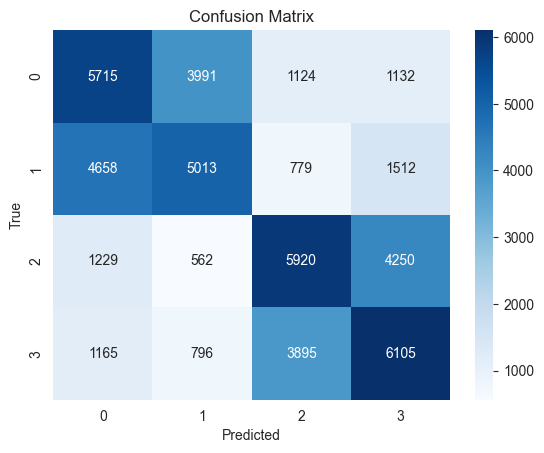

In [17]:
y_pred = np.argmax(model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing Confusion Matrix
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Classification Report
classification_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.48      0.46     11962
           1       0.48      0.42      0.45     11962
           2       0.51      0.49      0.50     11961
           3       0.47      0.51      0.49     11961

    accuracy                           0.48     47846
   macro avg       0.48      0.48      0.48     47846
weighted avg       0.48      0.48      0.48     47846



In [22]:
# Saving the model
model.save('saved_models/model2.h5')

In [8]:
# Load the saved model
loaded_model = tf.keras.models.load_model('saved_models/model2.h5')

# Selecting 9 random indices from the test dataset
random_indices = np.random.choice(len(X_test), size=9, replace=False)

# Extract the subset of data
X_subset = X_test[random_indices]
y_subset = y_test[random_indices]

# Evaluate the model on the subset
results = model.evaluate(X_subset, y_subset, verbose=0)

# Display the evaluation results
print(f'Model Accuracy on Subset: {results[1]*100:.2f}%')

ValueError: Unknown layer: KerasLayer. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.